# Linear Regression in eager mode

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

In [2]:
tf.enable_eager_execution()

In [3]:
def read_birth_life_data(filename):
    """Read in birth_life_2010.txt and return:
    data in the form of NumPy array
    n_samples: number of samples
    """
    text = open(filename, 'r').readlines()[1:]
    data = [line[:-1].split('\t') for line in text]
    births = [float(line[1]) for line in data]
    lifes = [float(line[2]) for line in data]
    data = list(zip(births, lifes))
    n_samples = len(data)
    data = np.asarray(data, dtype=np.float32)
    return data, n_samples

In [4]:
DATA_FILE = '../datasets/birth_life_2010.txt'

data, n_samples = read_birth_life_data(DATA_FILE)
print("data.shape: {}\n".format(data.shape))
print(data)

data.shape: (190, 2)

[[ 1.822    74.82825 ]
 [ 3.869    70.81949 ]
 [ 3.911    72.15066 ]
 [ 5.578    61.999855]
 [ 1.579    73.92766 ]
 [ 4.229    67.465195]
 [ 1.15     81.641464]
 [ 3.86     72.30639 ]
 [ 3.142    68.484314]
 [ 3.951    62.44061 ]
 [ 2.16     80.70244 ]
 [ 2.141    76.30168 ]
 [ 2.002    64.662094]
 [ 2.504    68.19498 ]
 [ 3.451    68.76483 ]
 [ 2.635    74.02456 ]
 [ 1.092    80.775314]
 [ 2.747    67.064   ]
 [ 1.22     80.76195 ]
 [ 1.39     82.932686]
 [ 2.117    68.889656]
 [ 1.108    82.87805 ]
 [ 2.47     75.99427 ]
 [ 2.09     75.07688 ]
 [ 2.668    69.22583 ]
 [ 2.022    68.53214 ]
 [ 1.598    73.273094]
 [ 2.581    62.53622 ]
 [ 2.042    77.93202 ]
 [ 1.92     81.69512 ]
 [ 2.499    68.001   ]
 [ 1.94     80.402435]
 [ 1.445    70.27561 ]
 [ 2.399    64.86351 ]
 [ 2.088    73.696655]
 [ 3.297    67.2599  ]
 [ 1.5      82.24634 ]
 [ 1.98     81.45122 ]
 [ 1.39     81.62683 ]
 [ 1.57     79.42195 ]
 [ 1.4      75.1122  ]
 [ 1.4      73.936584]
 [ 1.54     

### `tf.data` 사용하여 dataset 만들기

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((data[:, 0], data[:, 1]))
print(dataset)

<TensorSliceDataset shapes: ((), ()), types: (tf.float32, tf.float32)>


In [6]:
import tensorflow.contrib.eager as tfe

## Phase1 : Build a graph

In [7]:
# Create variables.
w = tfe.Variable(0.0)
b = tfe.Variable(0.0)

# Define the linear predictor.
def prediction(x):
  return x * w + b

# Define loss functions of the form: L(y, y_predicted)
def squared_loss(y, y_predicted):
  return (y - y_predicted) ** 2

def huber_loss(y, y_predicted, m=1.0):
  """Huber loss."""
  t = y - y_predicted
  # Note that enabling eager execution lets you use Python control flow and
  # specificy dynamic TensorFlow computations. Contrast this implementation
  # to the graph-construction one found in `utils`, which uses `tf.cond`.
  return t ** 2 if tf.abs(t) <= m else m * (2 * tf.abs(t) - m)

## Phase 2 : Training a model

In [8]:
def train(loss_fn):
  """Train a regression model evaluated using `loss_fn`."""
  print('Training; loss function: ' + loss_fn.__name__)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

  # Define the function through which to differentiate.
  def loss_for_example(x, y):
    return loss_fn(y, prediction(x))

  # `grad_fn(x_i, y_i)` returns (1) the value of `loss_for_example`
  # evaluated at `x_i`, `y_i` and (2) the gradients of any variables used in
  # calculating it.
  grad_fn = tfe.implicit_value_and_gradients(loss_for_example)

  start = time.time()
  for epoch in range(100):
    total_loss = 0.0
    for x_i, y_i in tfe.Iterator(dataset):
      loss, gradients = grad_fn(x_i, y_i)
      # Take an optimization step and update variables.
      optimizer.apply_gradients(gradients)
      total_loss += loss
    if epoch % 10 == 0:
      print('Epoch {0}: {1}'.format(epoch, total_loss / n_samples))
  print('Took: %f seconds' % (time.time() - start))
  print('Eager execution exhibits significant overhead per operation. '
        'As you increase your batch size, the impact of the overhead will '
        'become less noticeable. Eager execution is under active development: '
        'expect performance to increase substantially in the near future!')

In [9]:
train(huber_loss)

Training; loss function: huber_loss
Epoch 0: 106.16918182373047
Epoch 10: 53.64773178100586
Epoch 20: 42.586669921875
Epoch 30: 31.845298767089844
Epoch 40: 21.576385498046875
Epoch 50: 12.379732131958008
Epoch 60: 8.386137962341309
Epoch 70: 7.563107013702393
Epoch 80: 7.398852348327637
Epoch 90: 7.382768630981445
Took: 17.686973 seconds
Eager execution exhibits significant overhead per operation. As you increase your batch size, the impact of the overhead will become less noticeable. Eager execution is under active development: expect performance to increase substantially in the near future!


### Plot the result

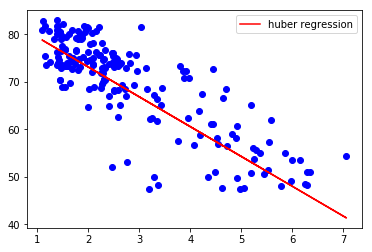

In [10]:
plt.plot(data[:,0], data[:,1], 'bo')
# The `.numpy()` method of a tensor retrieves the NumPy array backing it.
# In future versions of eager, you won't need to call `.numpy()` and will
# instead be able to, in most cases, pass Tensors wherever NumPy arrays are
# expected.
plt.plot(data[:,0], data[:,0] * w.numpy() + b.numpy(), 'r',
         label="huber regression")
plt.legend()
plt.show()